In [1]:
from PIL import Image,ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import scipy
from scipy.signal import wiener
from scipy.signal import convolve2d
from __future__ import division
import scipy.stats as stats
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def ListofFiles(path):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             filelist.append(os.path.join(root,file))
    return filelist

def getImageValues(Files,EventLimit=1):
    if(type(Files) is list):
        values={}
        count=0
        for file in Files:
            img1=Image.open(file)
            imgArray=np.array(img1)
            values[count]=imgArray
            count+=1
            if(EventLimit==count):
                break
        print(f" {count} frames in dictinary ")
    else:
        img1=Image.open(Files)
        values=np.array(img1)
    return values

def AverageIt(data):
    count=0
    Total=0
    for i in range (0,len(data)):
        Total+=data[i]  
        count+=1
    Averaged=Total/count
    values=0
    for i in range (0,len(data)):
        values+=(data[i]-Averaged)**2
        
    stdev=np.sqrt(values/(count-1))    
    print(f"Total Events Averaged is {count}")
    
    return Averaged,stdev

def PlotSideBySide(EL,Background):
    fig, axs = plt.subplots(1, 2,figsize=(15,12))
    BkSubstracted=EL-Background[0]
    axs[0].set_title("BackGround Substracted")
    axs[0].imshow(BkSubstracted,cmap='gray')
    axs[1].set_title("With Background")
    axs[1].imshow(EL,cmap='gray')

    plt.show()

def Plot(EL):
    plt.figure(figsize=(15,12))
    plt.title("Tracks")
    plt.imshow(EL)

    plt.show()
#    https://www.owlnet.rice.edu/~elec539/Projects99/BACH/proj2/wiener.html




def Ppectrum(img,bgn,Title):

    npix=img.shape[0]

    ## Obtain the freq
    kfreq=np.fft.fftfreq(npix)*npix

    ## Create a meshgrid
    kfreq2D=np.meshgrid(kfreq,kfreq)
    ## Normalize it
    knrm=np.sqrt(kfreq2D[0]**2+kfreq2D[1]**2)

    ## Convert it to 1d array
    knrm=knrm.flatten()
    Fourier_Amplitudes_img1=img.flatten()
    Fourier_Amplitudes_background=bgn.flatten()
    print(len(Fourier_Amplitudes_img1))
    ### binning 
    kbins = np.arange(0.5, npix//2+1, 1)

    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, Fourier_Amplitudes_img1,
                                         statistic = "mean",
                                         bins = kbins)
    AbinsBackground, _, _ = stats.binned_statistic(knrm, Fourier_Amplitudes_background,
                                         statistic = "mean",
                                         bins = kbins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    AbinsBackground *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

    '''ImgY=Abins/kvals
    BgY=AbinsBackground/kvals
    ### Mask it
    xlow=25
    xhigh=240
    Mask=np.where(np.logical_and(kvals>=xlow,kvals<=xhigh))
    

    
    IntegralBG=np.trapz(BgY[Mask],dx=1)
    IntegralSig=np.trapz(ImgY[Mask],dx=1)
    BgNormed=BgY*(IntegralSig/IntegralBG)
    
    weiner=(ImgY-BgNormed)/ImgY
    weinerNormed=(np.trapz(ImgY,dx=1)/np.trapz(weiner,dx=1))*weiner
    WeinerMask=kvals>=xlow
    weinerNormed[WeinerMask]=0
    weiner[WeinerMask]=0
    WeinerNanMask=np.isnan(weiner)
    weiner[WeinerNanMask]=0
    '''

      #WeinerByForce=(ImgY-BgY)/ImgY
    #WeinerByForceNormed=(np.trapz(ImgY,dx=1)/np.trapz(WeinerByForce,dx=1))*WeinerByForce
    #WeinerByForceNormed[WeinerMask]=0
    print(f"Minimum kval = {min(kvals)} and Maximum kval= {max(kvals)}")
    plt.plot(kvals,Abins/kvals,label="signal")
    plt.plot(kvals,AbinsBackground/kvals,label="Background")
    #plt.plot(kvals,weinerNormed,label="Weiner")

    #plt.plot(kvals,WeinerByForceNormed,label="Forced",color='y')
    plt.loglog()
    #plt.axvline(xlow,color='r')
    #plt.axvline(xhigh,color='r',label="IntegrationWindow")
    #print((Abins/kvals))
    #print(kvals)
    
    plt.axvline(25)
    plt.axvline(512)
  
    plt.title(Title)
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
    plt.legend()
    plt.show()
    #plt.savefig("img1_power_spectrum.png", dpi = 300, bbox_inches = "tight")

def PlotSideBySideWiner(EL,noise=(10,10)):
    fig, axs = plt.subplots(1, 2,figsize=(15,12))
    axs[0].set_title("Actual")
    axs[0].imshow(EL)
    axs[1].set_title("Winer Filtered")
    WinerFiltered=wiener(EL,noise)
    axs[1].imshow(WinerFiltered)

    plt.show()

def getPowerSpectrum(imgs,backgrounds,Name,xlow=100,xhigh=200):
    # take dft
    
    TotalNoisePS=0
    TotalDataPS=0
    imgdata=0
    bgdata=0
    DataCount=0
    BgnCount=0
    Signalhist=np.array([])
    Noisehist=np.array([])
    Filename=Name+".p"
    Values={}

    if(not(os.path.exists(Filename))): 
        for background in backgrounds:
            bgndfft=np.fft.fft2(backgrounds[background])
            bgspecnoise=(np.abs(bgndfft))**2
            TotalNoisePS+=bgspecnoise
            bgdata+=backgrounds[background]
            BgnCount+=1
            #Noisehist=np.append(Noisehist,np.ndarray.flatten(bgspecnoise))

        for  data in imgs :
            datadft = np.fft.fft2(imgs[data])
            signalps=(np.abs(datadft))**2
            TotalDataPS += signalps
            imgdata+=imgs[data]
            DataCount+=1
            #Signalhist=np.append(Signalhist,np.ndarray.flatten(signalps))
        
        AvgNoiseSpec=TotalNoisePS/BgnCount
        AvgDataSpec=TotalDataPS/DataCount
        
        NormAvgNoiseSpec=AvgNoiseSpec/np.max(AvgNoiseSpec)
        NormAvgDataSpec=AvgDataSpec/np.max(AvgDataSpec)
        print(NormAvgDataSpec)
        wiener1 = (NormAvgDataSpec-NormAvgNoiseSpec)/(NormAvgDataSpec)
        
        imgdataAvg=(imgdata/DataCount)
        BgndataAvg=(bgdata/BgnCount)
        Values["imgs"]=imgdataAvg
        Values["bgns"]=BgndataAvg
        Values["PSData"]=AvgDataSpec
        Values["PSBg"]=AvgNoiseSpec
        Values["Wiener2D"]=wiener1
        PickleITDump(Values,Filename)

    else:
        Values=PickleITRead(Filename)
        wiener1=Values["Wiener2D"]
        AvgDataSpec=Values["PSData"]
        AvgNoiseSpec=Values["PSBg"]
        imgdataAvg=Values["imgs"]
        BgndataAvg=Values["bgns"]
        
        NormAvgNoiseSpec=AvgNoiseSpec/np.max(AvgNoiseSpec)
        NormAvgDataSpec=AvgDataSpec/np.max(AvgDataSpec)
        
        wiener1 = (NormAvgDataSpec-NormAvgNoiseSpec)/(NormAvgDataSpec)
        
    print(f"Img Dimension --> {AvgNoiseSpec.shape[0]}x{AvgNoiseSpec.shape[1]}" )
    print(wiener1)
    # clip and convert to uint8
    #restored = restored.clip(0,255).astype(np.uint8)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 20), sharex=True, sharey=True)
    ax[0].set_title('All Images')
    ax[0].imshow(imgdataAvg,cmap='gray',origin="lower",vmin=np.mean(imgdataAvg),vmax=np.max(imgdataAvg))
    ax[1].set_title('All Background')
    ax[1].imshow(BgndataAvg,cmap='gray',origin="lower",vmin=np.mean(BgndataAvg),vmax=np.max(BgndataAvg))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 20), sharex=True, sharey=True)
    ax[0].set_title('2D FFT Images')
    ax[0].imshow(10*np.log10(AvgDataSpec),cmap='gray')
    ax[1].set_title('2D FFT Background')
    ax[1].imshow(10*np.log10(AvgNoiseSpec),cmap='gray')
    plt.show()
    
    #### Normalizing the 2D
    xx=np.arange(0,512,1)
    pixels=np.meshgrid(xx,xx)
    pixelsR=np.sqrt((pixels[0]-255)**2+(pixels[1]-255)**2)
    MaskX=np.where(np.logical_and(pixelsR>=xlow,pixelsR<=xhigh))


    IntegralBGX=np.trapz(BgndataAvg[MaskX],dx=1)
    IntegralSigX=np.trapz(imgdataAvg[MaskX],dx=1)
    AvgNoiseSpecNormed=1.05*AvgNoiseSpec*(IntegralSigX/IntegralBGX)
    wiener2=(AvgDataSpec-AvgNoiseSpecNormed)/AvgDataSpec
    NegativeMask=wiener2<0
    wiener2[NegativeMask]=0
    
    return wiener2,AvgNoiseSpec,AvgDataSpec,BgndataAvg,imgdataAvg

def PlotSinglePowerSpect(data,background,title):
  
    datafreqs=np.fft.fftfreq(data.shape[0])
    
    ps=np.ndarray.flatten(data)
    psnoise=np.ndarray.flatten(background)

    idx1 = np.argsort(datafreqs)
    plt.plot(datafreqs[idx1],ps[idx1],label="signal")
    plt.plot(datafreqs[idx1],psnoise[idx1],label="bgn")
    plt.title(title)
    plt.xlabel("Freq(Hz)")
    plt.ylabel("PowerSpec")
    plt.legend()
    plt.loglog()
    plt.show()

    
def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data
    
def RadialFilter(wiener,size,xcenter,ycenter,radius):
    xx=np.linspace(0,size,size)
    grid=np.meshgrid(xx,xx)
    r=np.round(np.sqrt((grid[0]-xcenter)**2+(grid[1]-ycenter)**2))
    
    MaskIn=r<radius
    MaskOut=r>=radius    
    ones=np.ones(r.shape)
    ones[MaskOut]=0
    positions=np.where(MaskIn)
    positionR=np.floor(np.sqrt((positions[0]-xcenter)**2+(positions[1]-ycenter)**2))
    print(positionR.max())
    print(positionR.min())

    Wiener1d=np.array([])

    for i in positionR:
        Wiener1d=np.append(Wiener1d,wiener[int(i)])
        
    ones[MaskIn]=Wiener1d
    
    return ones


#########  Using guide from following web page to obtaine power spectrum
####   https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
    
def PpectrumNormed(img,bgn,Title,file,xlow=25,xhigh=256,ZeroOut=False,ReadFile=True):
    if(file and ReadFile):
        Values=PickleITRead(file)
        img=Values["PSData"]
        bgn=Values["PSBg"]
    
    npix=img.shape[0]

    ## Obtain the freq
    kfreq=np.fft.fftfreq(npix)*npix

    ## Create a meshgrid
    kfreq2D=np.meshgrid(kfreq,kfreq)
    ## Normalize it
    knrm=np.sqrt(kfreq2D[0]**2+kfreq2D[1]**2)

    ## Convert it to 1d array
    knrm=knrm.flatten()
    Fourier_Amplitudes_img1=img.flatten()
    Fourier_Amplitudes_background=bgn.flatten()
    #print(len(Fourier_Amplitudes_img1))
    ### binning 
    
    kbins = np.arange(0.5, npix//2+1, 1.)
    #kbins = np.arange(1, npix, 1.)

    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, Fourier_Amplitudes_img1,
                                         statistic = "mean",
                                         bins = kbins)
    AbinsBackground, _, _ = stats.binned_statistic(knrm, Fourier_Amplitudes_background,
                                         statistic = "mean",
                                         bins = kbins)
    
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
 
    
    AbinsBackground *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
   

    ImgY=Abins/kvals
    BgY=AbinsBackground/kvals
    
    ### Mask it
    
    Mask=np.where(np.logical_and(kvals>=xlow,kvals<=xhigh))
    IntegralBG=np.trapz(BgY[Mask],dx=1)
    IntegralSig=np.trapz(ImgY[Mask],dx=1)
    BgNormed=BgY *(IntegralSig/IntegralBG)
    
    
    weiner=(ImgY-BgNormed)/ImgY
    weinerNormed=(np.trapz(ImgY,dx=1)/np.trapz(weiner,dx=1))*weiner
    WeinerMask=kvals>=xlow
    
    #weinerNormed[WeinerMask]=0.5
    #weiner[WeinerMask]=0.5
    if(ZeroOut):
        weinerNormed[WeinerMask]=0
        weiner[WeinerMask]=0

    
    #### Set Negative Values to Zero
    NegativeMask=weiner<0
    weinerNormed[NegativeMask]=0
    weiner[NegativeMask]=0


    print(f"Minimum kval = {min(kvals)} and Maximum kval= {max(kvals)}")
    plt.plot(kvals,ImgY,label="Signal")
    plt.plot(kvals,BgNormed,label="BackgroundNormed")
    plt.plot(kvals,BgY,label="Background")

    plt.plot(kvals,weinerNormed,label="Weiner")

    #plt.plot(kvals,WeinerByForceNormed,label="Forced",color='y')
    plt.loglog()
    plt.axvline(xlow,color='m')
    plt.axvline(xhigh,color='m',label="IntegrationWindow")
    #print((Abins/kvals))
    #print(kvals)
    
    plt.title(Title)
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
    #plt.ylim(1e5)
    plt.legend()
    plt.show()
    
    Newkvals=np.arange(1,513,1)
    NewImgY=ImgY
    NewImgY=np.append(NewImgY,np.flip(ImgY))
    
    NewBgNormed=BgNormed
    NewBgNormed=np.append(NewBgNormed,np.flip(BgNormed))
    NewweinerNormed=weinerNormed
    NewweinerNormed=np.append(NewweinerNormed,np.flip(weinerNormed))
    Newweiner=weiner
    Newweiner=np.append(Newweiner,np.flip(weiner))

    
    plt.plot(Newkvals,NewImgY,label="Signal")
    plt.plot(Newkvals,NewBgNormed,label="BackgroundNormed")
    plt.plot(Newkvals,NewweinerNormed,label="Weiner")

    #plt.plot(kvals,WeinerByForceNormed,label="Forced",color='y')
    plt.semilogy()
    #print((Abins/kvals))
    #print(kvals)
    
    plt.title(Title)
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
    #plt.ylim(1e5)
    plt.legend()
    plt.show()
    
    if(ReadFile):
        Values["Wiener1D"]=weiner
        PickleITDump(Values,file)
    return Newweiner,weiner
    #plt.savefig("img1_power_spectrum.png", dpi = 300, bbox_inches = "tight")
    
def Wiener2x1DNormed(img,bgn,Title,file=" ",xlow=25,xhigh=200,ylow=25,yhigh=200,ZeroOut=False,ReadFile=True):
    if(file and ReadFile):
        Values=PickleITRead(file)
        img=Values["PSData"]
        bgn=Values["PSBg"]
    
    npix=img.shape[0]

    ## Obtain the freq
    kfreq=np.fft.fftfreq(npix)*npix

    ## Create a meshgrid
    kfreq2D=np.meshgrid(kfreq,kfreq)
 

    ## Convert it to 1d array
    kfreqX=kfreq2D[0].flatten()
    kfreqY=kfreq2D[1].flatten()

    Fourier_Amplitudes_img1=img.flatten()
    Fourier_Amplitudes_background=bgn.flatten()
    #print(len(Fourier_Amplitudes_img1))
    ### binning 
    
    kbins = np.arange(0.5, npix//2+1, 1.)
    #kbins = np.arange(1, npix, 1.)

    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    
    ### Getting Wiener Filter in  the X
    AbinsX, _, _ = stats.binned_statistic(kfreqX, Fourier_Amplitudes_img1,
                                         statistic = "mean",
                                         bins = kbins)
    AbinsBackgroundX, _, _ = stats.binned_statistic(kfreqX, Fourier_Amplitudes_background,
                                         statistic = "mean",
                                         bins = kbins)
    
    AbinsX *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
 
    
    AbinsBackgroundX *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
   

    ImgX=AbinsX/kvals
    BgX=AbinsBackgroundX/kvals
    
    ### Integrate between xlow and xhigh
    
    MaskX=np.where(np.logical_and(kvals>=xlow,kvals<=xhigh))
    IntegralBGX=np.trapz(BgX[MaskX],dx=1)
    IntegralSigX=np.trapz(ImgX[MaskX],dx=1)
    BgNormedX=BgX *(IntegralSigX/IntegralBGX)
    
    
    wienerX=(ImgX-BgNormedX)/ImgX
    wienerNormedX=(np.trapz(ImgX,dx=1)/np.trapz(wienerX,dx=1))*wienerX
    wienerMaskX=kvals>=xlow
    
    
    
    ### Getting the filter in the Y direction
    
  
    AbinsY, _, _ = stats.binned_statistic(kfreqY, Fourier_Amplitudes_img1,
                                         statistic = "mean",
                                         bins = kbins)
    AbinsBackgroundY, _, _ = stats.binned_statistic(kfreqY, Fourier_Amplitudes_background,
                                         statistic = "mean",
                                         bins = kbins)
    
    AbinsY *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
 
    
    AbinsBackgroundY *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
   

    ImgY=AbinsY/kvals
    BgY=AbinsBackgroundY/kvals
    
    ### Integrate between ylow and yhigh
    
    MaskY=np.where(np.logical_and(kvals>=ylow,kvals<=yhigh))
    IntegralBGY=np.trapz(BgY[MaskY],dx=1)
    IntegralSigY=np.trapz(ImgY[MaskY],dx=1)
    BgNormedY=BgY *(IntegralSigY/IntegralBGY)
    
    
    wienerY=(ImgY-BgNormedY)/ImgY
    wienerNormedY=(np.trapz(ImgY,dx=1)/np.trapz(wienerY,dx=1))*wienerY
    wienerMaskY=kvals>=ylow
    
    
    
    
    
    #weinerNormed[WeinerMask]=0.5
    #weiner[WeinerMask]=0.5
    if(ZeroOut):
        wienerNormedX[wienerMaskX]=0
        wienerX[wienerMaskX]=0
        
        wienerNormedY[wienerMaskY]=0
        wienerY[wienerMaskY]=0


    
    #### Set Negative Values to Zero
    NegativeMaskX=wienerX<0
    wienerNormedX[NegativeMaskX]=0
    wienerX[NegativeMaskX]=0
    
    NegativeMaskY=wienerY<0
    wienerNormedY[NegativeMaskY]=0
    wienerY[NegativeMaskY]=0



    print(f"Minimum kval = {min(kvals)} and Maximum kval= {max(kvals)}")
    plt.plot(kvals,ImgX,label="signalX")
    plt.plot(kvals,BgNormedX,label="BackgroundNormedX")
    plt.plot(kvals,BgX,label="BackgroundX")

    plt.plot(kvals,wienerNormedX,label="wienerX")

    #plt.plot(kvals,WeinerByForceNormed,label="Forced",color='y')
    plt.loglog()
    plt.axvline(xlow,color='r')
    plt.axvline(xhigh,color='r',label="IntegrationWindow")
    #print((Abins/kvals))
    #print(kvals)
    
    plt.title(Title)
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
    #plt.ylim(1e5)
    plt.legend()
    plt.show()
    
    
    plt.plot(kvals,ImgY,label="signalY")
    plt.plot(kvals,BgNormedY,label="BackgroundNormedY")
    plt.plot(kvals,BgY,label="BackgroundY")

    plt.plot(kvals,wienerNormedY,label="wienerY")

    #plt.plot(kvals,WeinerByForceNormed,label="Forced",color='y')
    plt.loglog()
    plt.axvline(ylow,color='m')
    plt.axvline(yhigh,color='m',label="IntegrationWindow")
    #print((Abins/kvals))
    #print(kvals)
    
    plt.title("WienerY")
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
    #plt.ylim(1e5)
    plt.legend()
    plt.show()
    
    if(ReadFile):
        Values["Wiener1DX"]=wienerX
        Values["Wiener1DY"]=wienerY

        PickleITDump(Values,file)
        

    wienerXNanMask=np.isnan(wienerX)
    wienerYNanMask=np.isnan(wienerY)
    wienerX[wienerXNanMask]=0
    wienerY[wienerYNanMask]=0
    wienerX=np.append(wienerX,np.flip(wienerX))
    wienerY=np.append(wienerY,np.flip(wienerY))
    return wienerX,wienerY
    #plt.savefig("img1_power_spectrum.png", dpi = 300, bbox_inches = "tight")    

def gkern(l=5, sig=10.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

In [3]:

##### Day 1 ####
if(not(os.path.exists("NoELDay1.p"))): 
    NoEl=ListofFiles("/home/ilker/Desktop/Camera Tracks/07.22.22/10kVgap_Pb210/EL-NoEL/NoEl")
    BackGround=getImageValues(NoEl,EventLimit=-1)
    PickleITDump(BackGround,"NoELDay1.p")
else:
    BackGround=PickleITRead("NoELDay1.p")
    
if(not(os.path.exists("ELDay1.p"))):
    Day1El=ListofFiles("/home/ilker/Desktop/Camera Tracks/07.22.22/10kVgap_Pb210/EL-NoEL/EL")
    ELDay1Images=getImageValues(Day1El,EventLimit=-1)
    PickleITDump(ELDay1Images,"ELDay1.p")
else:
    ELDay1Images=PickleITRead("ELDay1.p")

#### Day 2 ###    
if(not(os.path.exists("NoELDay.p"))):
    NoELDay2=ListofFiles("/home/ilker/Desktop/Camera Tracks/07.23.22/0kV EL")
    BackGroundDay2=getImageValues(NoELDay2,EventLimit=-1)
    PickleITDump(BackGroundDay2,"NoELDay.p")
else:
    BackGroundDay2=PickleITRead("NoELDay.p")
    
if(not(os.path.exists("ELDay2.p"))):
    Day2El=ListofFiles("/home/ilker/Desktop/Camera Tracks/07.23.22/10kV EL")
    ELDay2Images=getImageValues(Day2El,EventLimit=-1)
    PickleITDump(ELDay2Images,"ELDay2.p")
else:
    ELDay2Images=PickleITRead("ELDay2.p")

#BackGroundDay2=getImageValues(NoELDay2,EventLimit=-1)
#ELDay2Images=getImageValues(Day2El,EventLimit=-1)

        

Img Dimension --> 512x512
[[0.         0.85052283 0.96605593 ... 0.98242458 0.96605593 0.85052283]
 [0.98325466 0.99966519 0.99973572 ... 0.9997084  0.9997027  0.99962498]
 [0.96867341 0.9996528  0.99969764 ... 0.99966847 0.99971251 0.99962026]
 ...
 [0.96442342 0.99959079 0.99966614 ... 0.99962416 0.99966329 0.99959438]
 [0.96867341 0.99962026 0.99971251 ... 0.99968974 0.99969764 0.9996528 ]
 [0.98325466 0.99962498 0.9997027  ... 0.999712   0.99973572 0.99966519]]


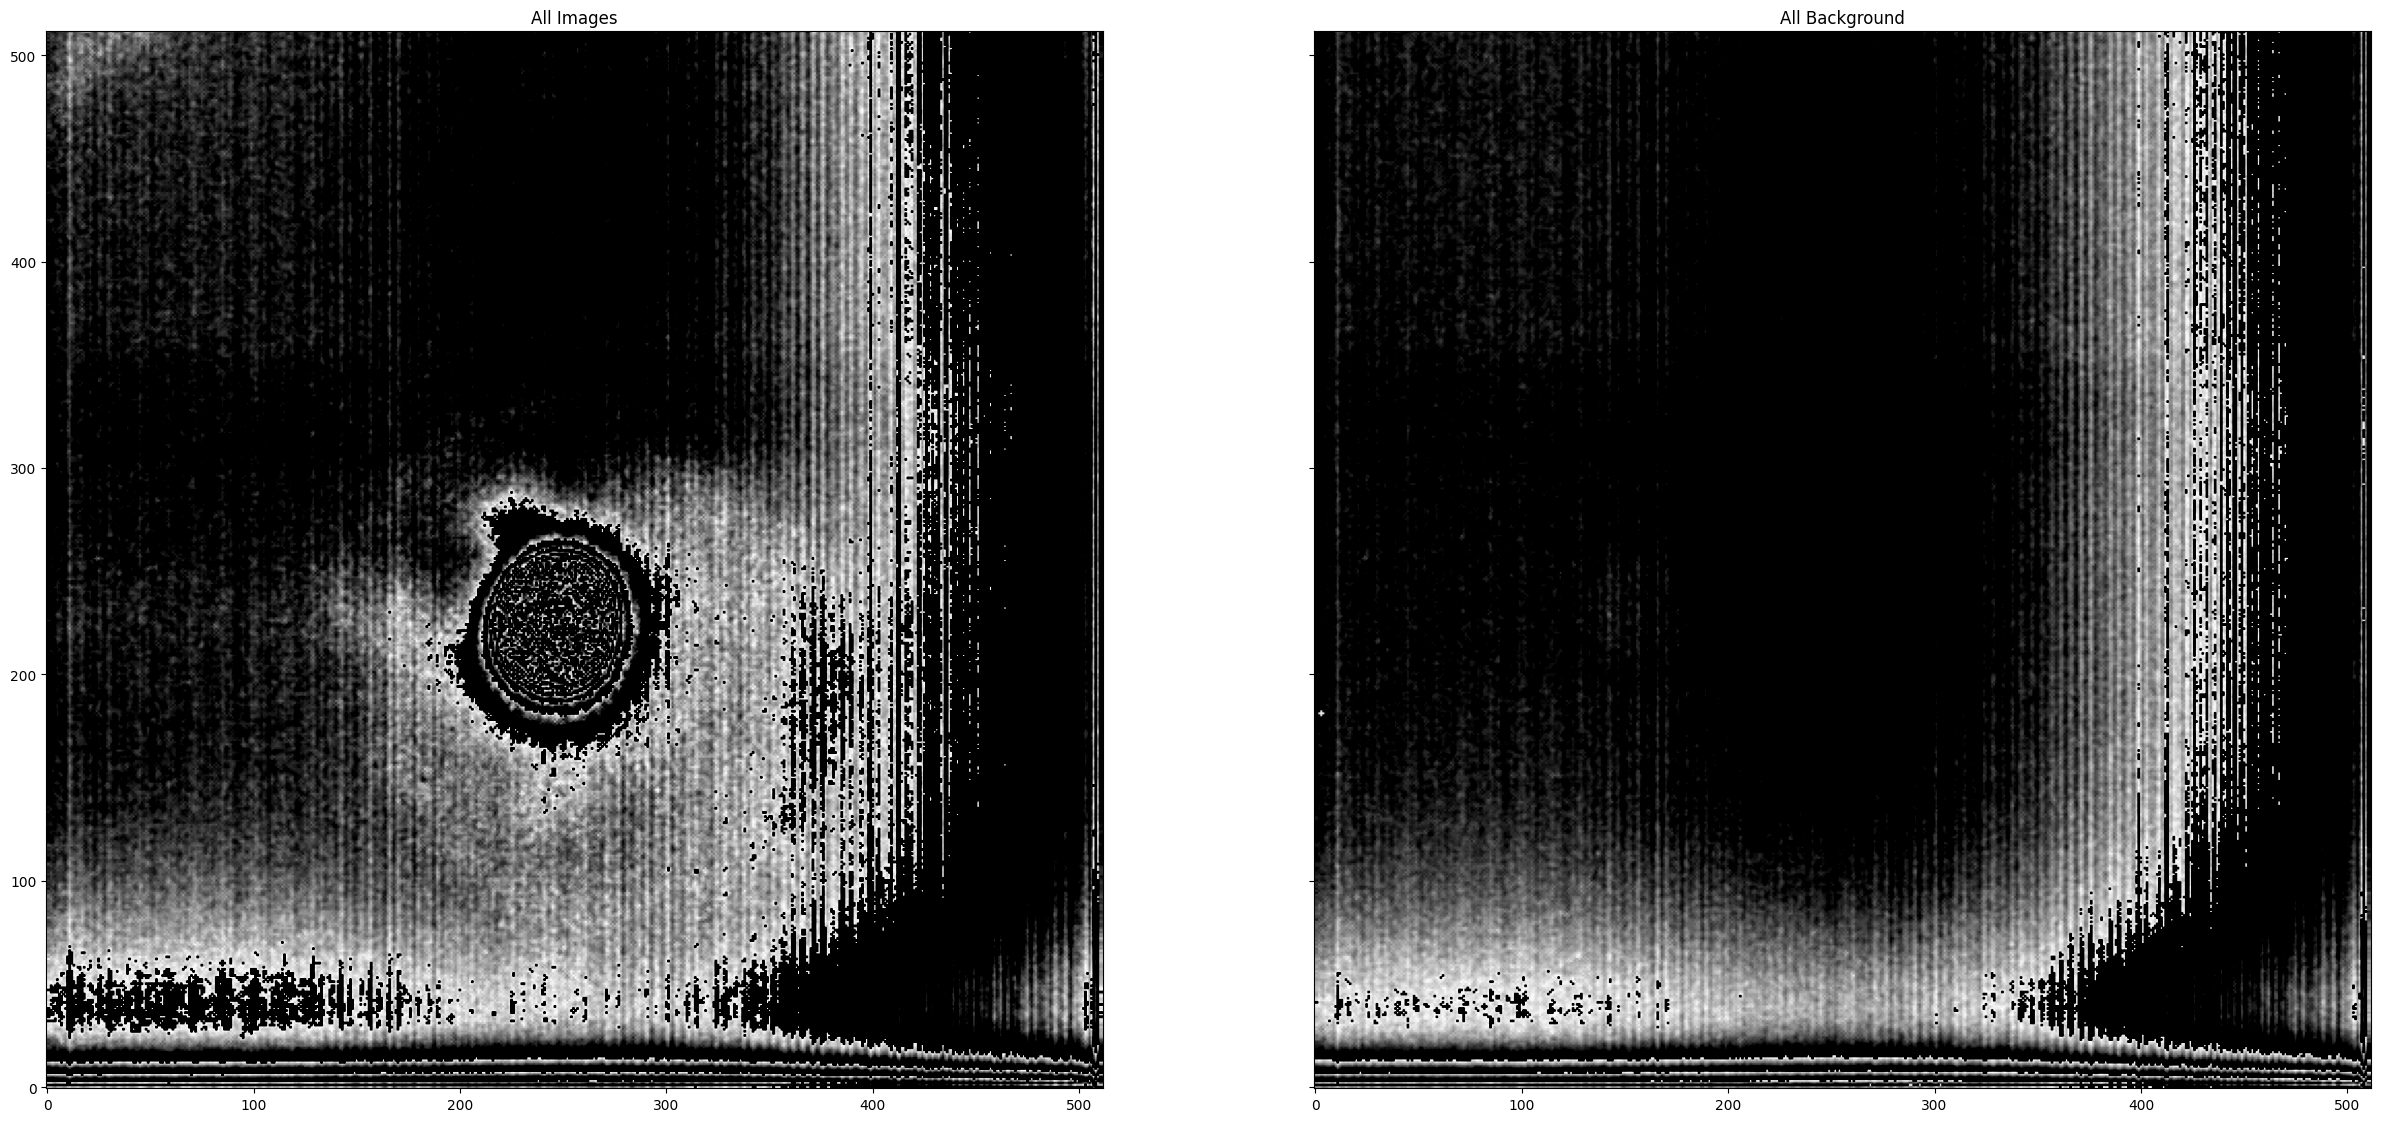

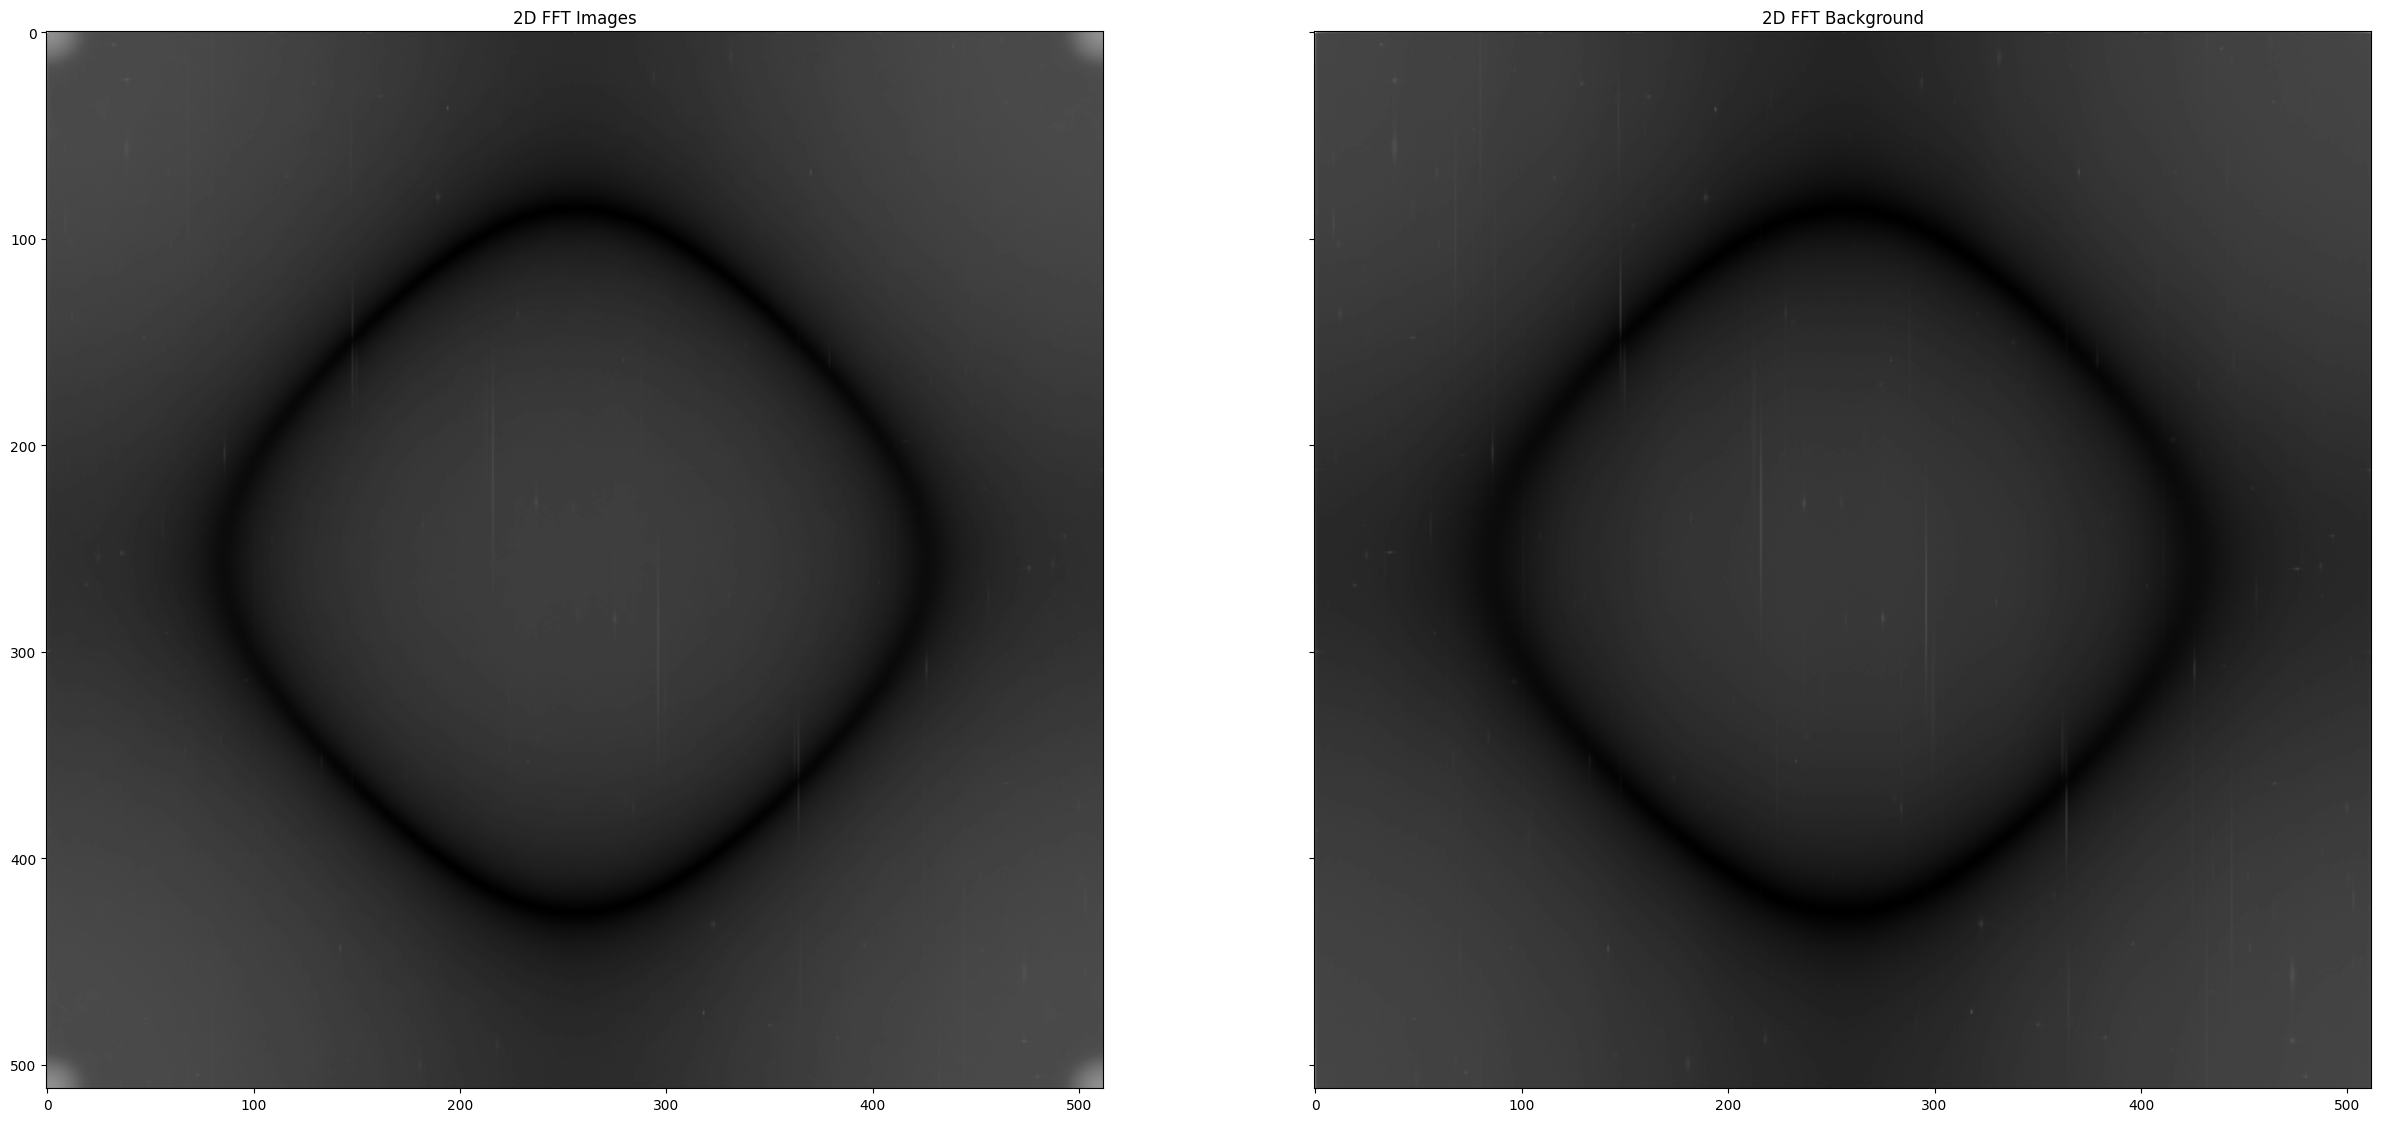

In [4]:
##### Day 1 For All the Images ####
pws=getPowerSpectrum(ELDay1Images,BackGround,"WienerDay1",xlow=40,xhigh=50)

In [5]:
print(pws[0])

[[0.         0.6847748  0.92841698 ... 0.96293605 0.92841698 0.6847748 ]
 [0.96468655 0.99929394 0.99944267 ... 0.99938506 0.99937304 0.99920914]
 [0.93393685 0.99926782 0.99936237 ... 0.99930086 0.99939373 0.99919917]
 ...
 [0.92497426 0.99913704 0.99929593 ... 0.9992074  0.99928994 0.99914461]
 [0.93393685 0.99919917 0.99939373 ... 0.99934571 0.99936237 0.99926782]
 [0.96468655 0.99920914 0.99937304 ... 0.99939266 0.99944267 0.99929394]]


Minimum kval = 1.0 and Maximum kval= 256.0


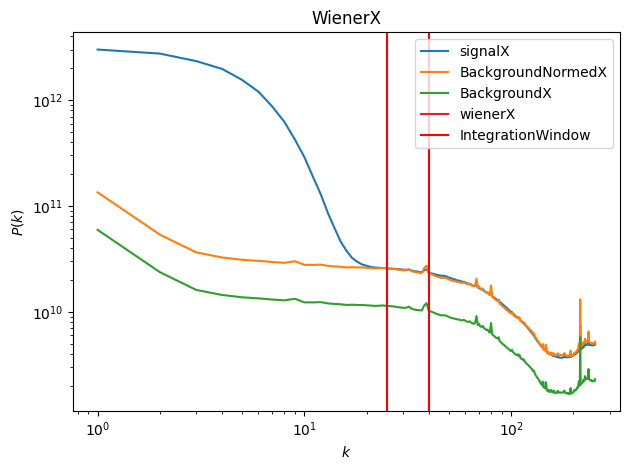

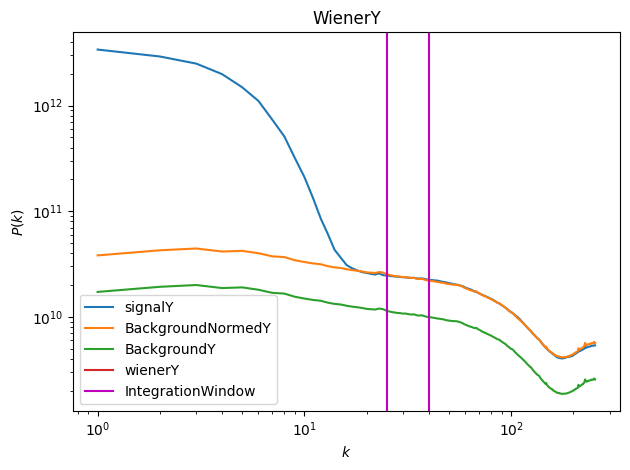

In [6]:
Wiener2x=Wiener2x1DNormed(pws[2],pws[1],"WienerX",xlow=25,xhigh=40,ylow=25,yhigh=40,ZeroOut=False,ReadFile=False)
xx,yy=np.meshgrid(Wiener2x[0],Wiener2x[1])


Minimum kval = 1.0 and Maximum kval= 256.0


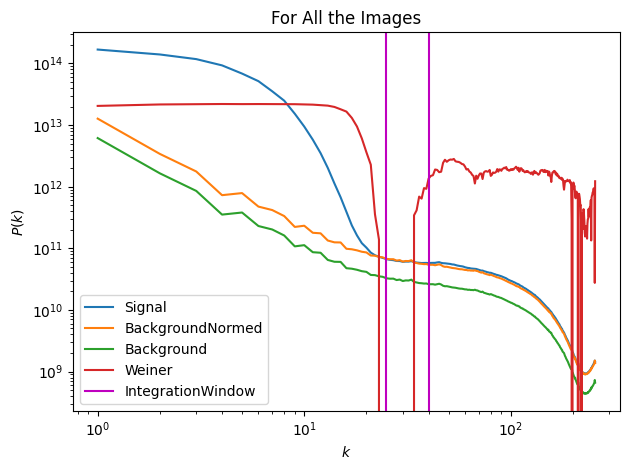

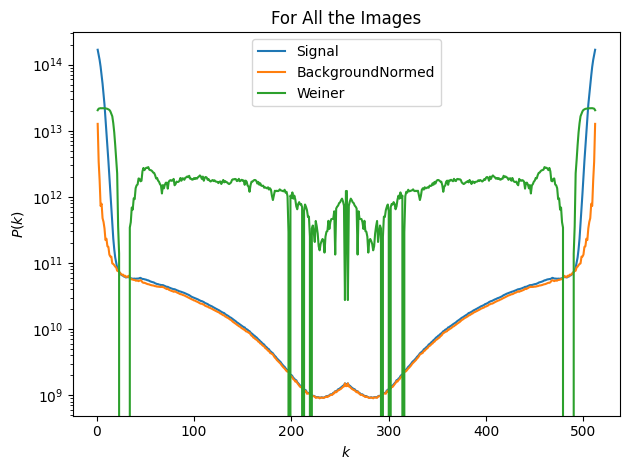

255.0
0.0
0.9921712511333179


In [7]:
### Increase array size to 512 

Wiener1d=PpectrumNormed(pws[2],pws[1],"For All the Images","WienerDay1.p",xlow=25,xhigh=40,ZeroOut=False)
WienerR=RadialFilter(Wiener1d[1],512,256,255,255)
print(np.max(Wiener1d[0]))

In [8]:
hs={}
for h in range(1,30):
    if(not h%2==0):
        hs[h]=gkern(h,5.)

H_1 = np.fft.fft2(hs[15], (512,512))
print(H_1)

[[1.        +0.00000000e+00j 0.995279  -8.57083033e-02j
  0.98119348-1.70253219e-01j ... 0.95797426+2.52492949e-01j
  0.98119348+1.70253219e-01j 0.995279  +8.57083033e-02j]
 [0.995279  -8.57083033e-02j 0.98323438-1.70607349e-01j
  0.96196915-2.53545883e-01j ... 0.97509241+1.69194583e-01j
  0.99115338+8.53530262e-02j 0.99792621+2.16840434e-17j]
 [0.98119348-1.70253219e-01j 0.96196915-2.53545883e-01j
  0.93375449-3.34102698e-01j ... 0.98294583+8.46462341e-02j
  0.9917268 +2.86229374e-17j 0.99115338-8.53530262e-02j]
 ...
 [0.95797426+2.52492949e-01j 0.97509241+1.69194583e-01j
  0.98294583+8.46462341e-02j ... 0.85396199+4.83763490e-01j
  0.89697036+4.10842637e-01j 0.93181092+3.33407279e-01j]
 [0.98119348+1.70253219e-01j 0.99115338+8.53530262e-02j
  0.9917268 +3.55618313e-17j ... 0.89697036+4.10842637e-01j
  0.93375449+3.34102698e-01j 0.96196915+2.53545883e-01j]
 [0.995279  +8.57083033e-02j 0.99792621+1.38777878e-17j
  0.99115338-8.53530262e-02j ... 0.93181092+3.33407279e-01j
  0.96196915+2

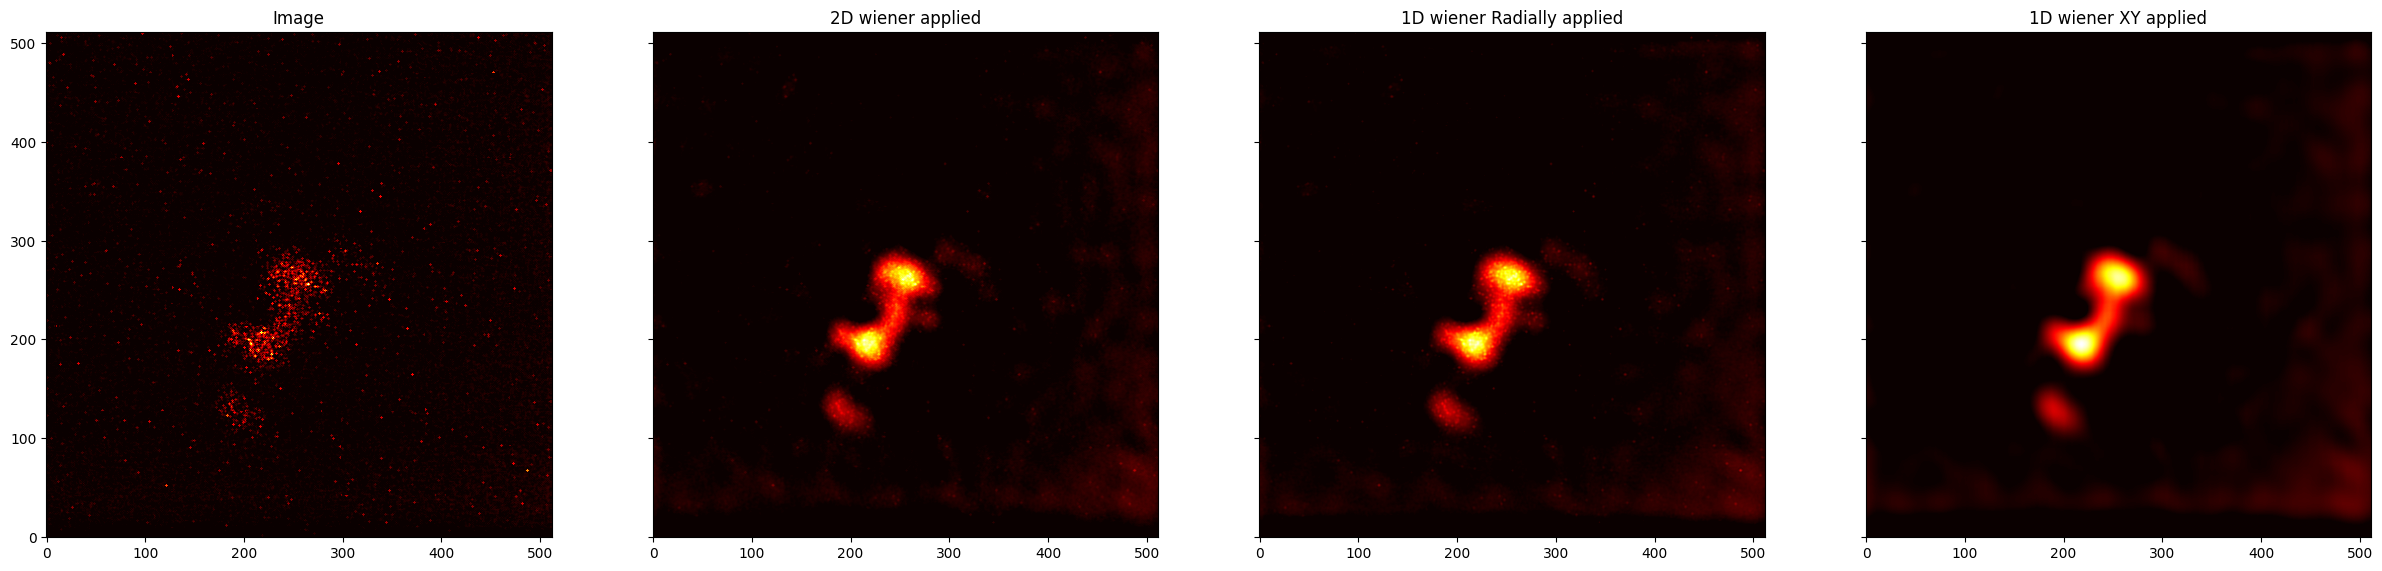

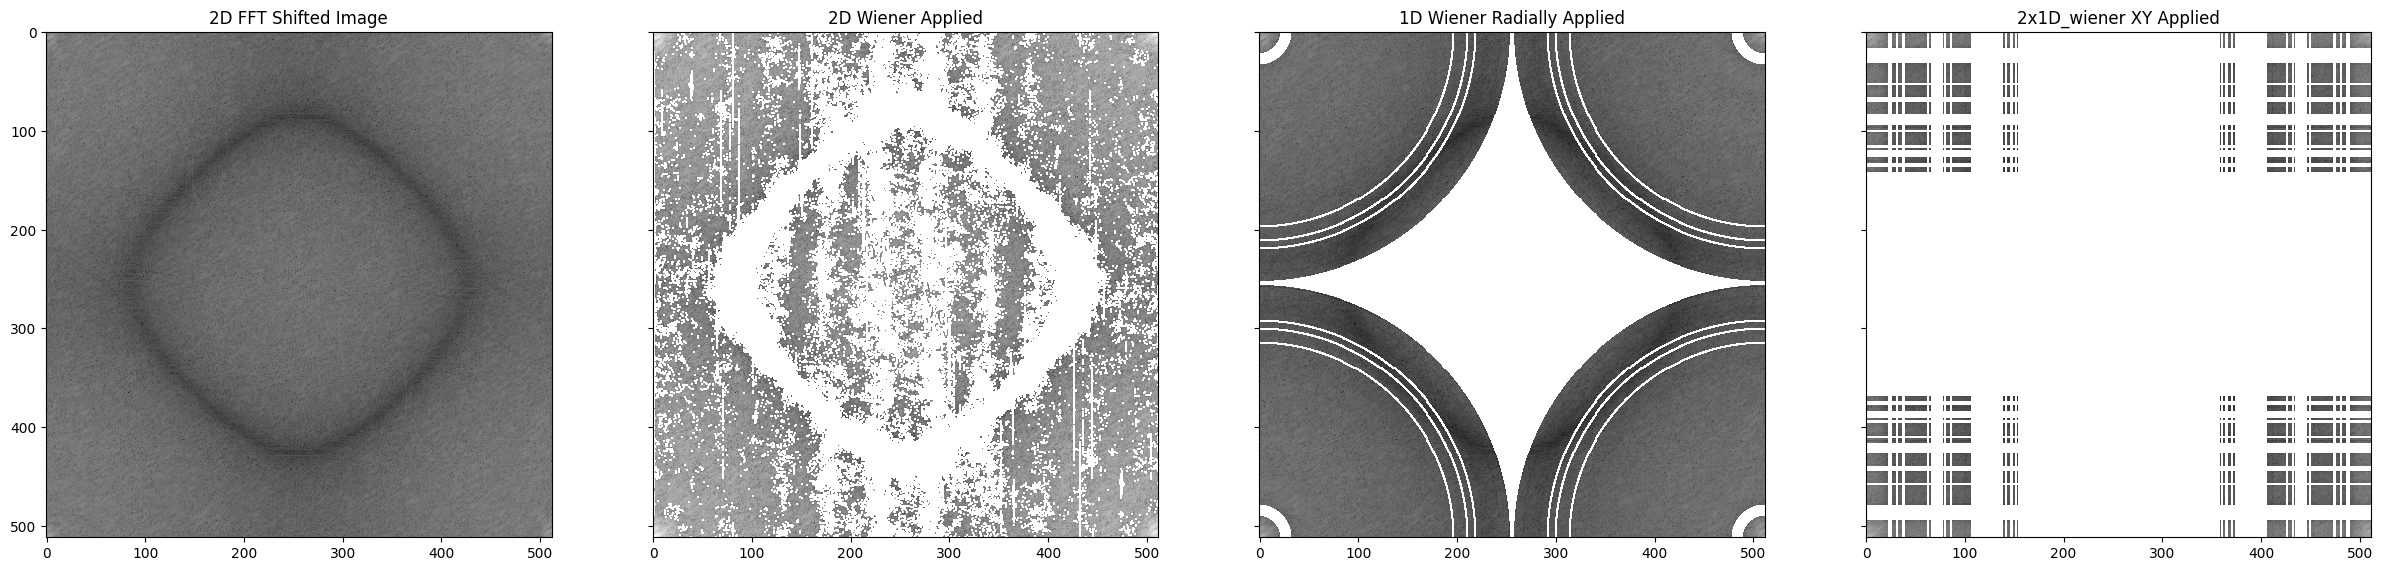

In [10]:
#ones=np.ones((25,25))/25
#ones=np.pad(ones,[(0, pws[2].shape[0]-ones.shape[0]), (0, pws[2].shape[1]-ones.shape[1])], mode='constant', constant_values=0)
#test=np.flip(test)
#### Single Image Recovery

SingleImg=ELDay1Images[1161]
fft_SingleImg=np.fft.fft2(SingleImg)

#print(fft_SingleImg[0])

## 2D wiener
restored2DWiener = (fft_SingleImg*pws[0])
restored2DWiener = np.fft.ifft2(restored2DWiener)
restored2DWiener = np.real(restored2DWiener)


## 1D Wiener Radially Applied
restored1DWienerR=np.fft.fftshift(fft_SingleImg)*WienerR
restored1DWienerR=np.fft.ifftshift(restored1DWienerR)
restored1DWienerR = np.fft.ifft2(restored1DWienerR)
restored1DWienerR = np.real(restored1DWienerR)


## 1D Wiener X,Y Applied
restored1DWienerXY=fft_SingleImg*xx*yy
restored1DWienerXY = np.fft.ifft2(restored1DWienerXY)
restored1DWienerXY = np.real(restored1DWienerXY)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 20), sharex=True, sharey=True)
ax[0].set_title('Image')
ax[0].imshow(SingleImg,cmap=plt.get_cmap('hot'),origin="lower", interpolation='nearest',vmin=(np.mean(SingleImg)), vmax=np.max(SingleImg))
ax[1].set_title('2D wiener applied')
ax[1].imshow(restored2DWiener,cmap=plt.get_cmap('hot'),origin="lower",vmin=(np.mean(restored2DWiener)), vmax=np.max(restored2DWiener))
ax[2].set_title('1D wiener Radially applied')
ax[2].imshow(restored1DWienerR,cmap=plt.get_cmap('hot'),origin="lower",vmin=(np.mean(restored1DWienerR)), vmax=np.max(restored1DWienerR))
ax[3].set_title('1D wiener XY applied')
ax[3].imshow(restored1DWienerXY,cmap=plt.get_cmap('hot'),origin="lower",norm=LogNorm(vmin=np.mean(restored1DWienerXY), vmax=np.max(restored1DWienerXY)))
#ax[3].set_title('Median')
#ax[3].imshow(test,cmap=plt.get_cmap('hot'),origin="lower", interpolation='nearest',vmin=(np.mean(test)), vmax=np.max(test))

#restore5 = restore5.clip(0,255).astype(np.uint8)

#ax[1].imshow(20*np.log10(abs(fft_SingleImg)*),cmap='gray')
plt.show()

fft2dSpectrum=10*np.log10(np.abs(fft_SingleImg)**2*np.fft.fftshift(WienerR))
#fft2dWienerSpectrum=10*np.log10(np.abs(fft_SingleImg)**2*pws[0])
fft2dWienerSpectrum=10*np.log10(np.abs(fft_SingleImg)**2*pws[0])
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 20), sharex=False, sharey=True)
#ax[0].set_title('2D FFT')
#ax[0].imshow(10*np.log10(np.abs(fft_SingleImg)**2),cmap='gray')
ax[0].set_title('2D FFT Shifted Image')
ax[0].imshow(10*np.log10(np.abs(fft_SingleImg)**2),cmap='gray')
ax[1].set_title('2D Wiener Applied')
ax[1].imshow(fft2dWienerSpectrum,cmap='gray')
ax[2].set_title('1D Wiener Radially Applied')
ax[2].imshow(fft2dSpectrum,cmap='gray')
ax[3].set_title('2x1D_wiener XY Applied')

ax[3].imshow(10*np.log10(np.abs(fft_SingleImg)**2*xx*yy),cmap='gray')

#ax[1].set_title('2D Weiner applied')
#ax[1].imshow(10*np.log10(np.abs(np.fft.fft(restored))),cmap='gray')
#ax[2].set_title('1D Weiner applied')
#ax[2].imshow(10*np.log10(np.abs(np.fft.fft(restored2))),cmap='gray')
plt.show()



In [ ]:
##### Day2
pwsday2=getPowerSpectrum(ELDay2Images,BackGroundDay2,"WienerDay2",xlow=150,xhigh=256)

In [ ]:
Wiener2xDay2=Wiener2x1DNormed(pwsday2[2],pwsday2[1],"WienerX_Day2",xlow=25,xhigh=200,ZeroOut=False,ReadFile=False)
xx2,yy2=np.meshgrid(Wiener2xDay2[0],Wiener2xDay2[1])

In [ ]:
#### Day 1 ####
#PlotPowerSpect(pws[2],pws[1],"Day_1_All_Images")
Wiener1d_Day2=PpectrumNormed(pwsday2[2],pwsday2[1],"For All the Images","WienerDay2.p",xlow=150,xhigh=256,ZeroOut=False)
WienerRDay2=RadialFilter(Wiener1d_Day2[1],512,256,255,255)


In [ ]:
### Day2
#PlotPowerSpect(pwsday2[2],pwsday2[1],"Day_2")


In [ ]:
# ones=np.ones((15,15))/100
#ones=np.pad(ones,[(0, pws[2].shape[0]-ones.shape[0]), (0, pws[2].shape[1]-ones.shape[1])], mode='constant', constant_values=0)

#### Single Image Recovery
#SingleImg=ELDay2Images[935]
#print(increment)

#print(PS_SingleImg)
#for i in increment:
SingleImg=ELDay2Images[935]

fft_SingleImg=np.fft.fft2(SingleImg)


## 2D wiener
restored2DWiener = fft_SingleImg*pwsday2[0]
restored2DWiener = np.fft.ifft2(restored2DWiener)
restored2DWiener = np.real(restored2DWiener)


## 1D Wiener Radially Applied
restored1DWienerR=np.fft.fftshift(fft_SingleImg)*WienerRDay2
restored1DWienerR=np.fft.ifftshift(restored1DWienerR)
restored1DWienerR = np.fft.ifft2(restored1DWienerR)
restored1DWienerR = np.real(restored1DWienerR)


## 1D Wiener X,Y Applied
restored1DWienerXY=fft_SingleImg*xx2*yy2
restored1DWienerXY = np.fft.ifft2(restored1DWienerXY)
restored1DWienerXY = np.real(restored1DWienerXY)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 20), sharex=True, sharey=True)
ax[0].set_title('Image')
ax[0].imshow(SingleImg,cmap=plt.get_cmap('hot'),origin="lower", interpolation='nearest',vmin=(np.mean(SingleImg)), vmax=np.max(SingleImg))
ax[1].set_title('2D wiener applied')
ax[1].imshow(restored2DWiener,cmap=plt.get_cmap('hot'),origin="lower",vmin=(np.mean(restored2DWiener)), vmax=np.max(restored2DWiener))
ax[2].set_title('1D wiener Radially applied')
ax[2].imshow(restored1DWienerR,cmap=plt.get_cmap('hot'),origin="lower",vmin=(np.mean(restored1DWienerR)), vmax=np.max(restored1DWienerR))
ax[3].set_title('1D wiener XY applied')
ax[3].imshow(restored1DWienerXY,cmap=plt.get_cmap('hot'),origin="lower",vmin=(np.mean(restored1DWienerXY)), vmax=np.max(restored1DWienerXY))


plt.show()

fft2dSpectrum=10*np.log10(np.abs(fft_SingleImg)**2*np.fft.fftshift(WienerRDay2))
fft2dWienerSpectrum=10*np.log10(np.abs(fft_SingleImg)**2*pwsday2[0])
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 20), sharex=True, sharey=True)
ax[0].set_title('2D FFT Shifted Image')
ax[0].imshow(10*np.log10(np.abs(fft_SingleImg)**2),cmap='gray')
ax[1].set_title('2D Wiener Applied')
ax[1].imshow(fft2dWienerSpectrum,cmap='gray')
ax[2].set_title('1D Wiener Radially Applied')
ax[2].imshow(fft2dSpectrum,cmap='gray')
ax[3].set_title('2x1D_wiener XY Applied')

ax[3].imshow(10*np.log10(np.abs(fft_SingleImg)**2*xx2*yy2),cmap='gray')

#ax[1].set_title('2D Weiner applied')
plt.show()

In [ ]:
test={}
test[0]=ELDay1Images[150]
bgn={}
count=0
for i in range(500,1000):
    
    bgn[count]=BackGround[i]
    count+=1

testpws=getPowerSpectrum(test,bgn,"wiener_test")
plt.show()
testWiener1d=PpectrumNormed(testpws[2],testpws[1],"For All the Images","wiener_test.p",ZeroOut=True)


In [ ]:
from scipy.ndimage import rotate

restored=np.fft.ifft2(np.fft.fft2(test[0])*(testWiener1d))
Angle=90
Times=int(360/Angle)
for i in range (0,Times):
    print(Angle)
    restored=rotate(np.real(restored), Angle,reshape=False)
    restored=np.fft.fft2(restored)*testWiener1d
    restored=np.real(np.fft.ifft2(restored))
    
    
restored2=np.fft.ifft2(np.fft.fft2(test[0])*(yy.T*yy*xx.T*yy.T))
restored2=np.real(restored2)



fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(50, 50))
ax[0].set_title('Image')
ax[0].imshow(test[0],cmap=plt.get_cmap('hot'),origin="lower",vmin=np.mean(test[0]), vmax=np.max(test[0]))
ax[1].set_title('2D Wiener')
ax[1].imshow(restored2,cmap=plt.get_cmap('hot'),origin="lower",vmin=np.mean(restored2), vmax=np.max(restored2))
ax[2].set_title('1D Wiener')
ax[2].imshow(restored,cmap=plt.get_cmap('hot'),origin="lower",vmin=np.mean(restored), vmax=np.max(restored))


plt.show()